<a href="https://colab.research.google.com/github/PangaGayathri/SentimentAnalysis/blob/main/Amazon_reviews_analysis_using_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#importing required libraries
import wordcloud
import pandas as pd
import tensorflow as tf
from textblob import Word
from collections import Counter
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import nltk
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D

In [6]:
#loading the dataset from tensrflow_datasets
ds = tfds.load('amazon_us_reviews/Mobile_Electronics_v1_00', split='train', shuffle_files=True)
assert isinstance(ds, tf.data.Dataset)
#converting the dataset to dataframe
data = tfds.as_dataframe(ds)
#creating a new column ‘sentiment’ based on ‘star_rating’.
data["Sentiment"] = data["data/star_rating"].apply(lambda score: "positive" if score >= 3 else "negative")
data['Sentiment'] = data['Sentiment'].map({'positive':1, 'negative':0})
data['verified_reviews'] =data['data/review_body'].str.decode("utf-8")

<_OptionsDataset shapes: {data: {customer_id: (), helpful_votes: (), marketplace: (), product_category: (), product_id: (), product_parent: (), product_title: (), review_body: (), review_date: (), review_headline: (), review_id: (), star_rating: (), total_votes: (), verified_purchase: (), vine: ()}}, types: {data: {customer_id: tf.string, helpful_votes: tf.int32, marketplace: tf.string, product_category: tf.string, product_id: tf.string, product_parent: tf.string, product_title: tf.string, review_body: tf.string, review_date: tf.string, review_headline: tf.string, review_id: tf.string, star_rating: tf.int32, total_votes: tf.int32, verified_purchase: tf.int64, vine: tf.int64}}>


In [9]:
#Checking for null values in the dataset
data_v1 = data[["verified_reviews", "Sentiment"]]
data_v1.isnull().sum()

verified_reviews    0
Sentiment           0
dtype: int64

In [11]:
#Cleaning the data like removing special characters, digits, stopwords... and converting words to their root words for easy interpretation
def cleaning(df, stop_words):
    df['verified_reviews'] = df['verified_reviews'].apply(lambda x:' '.join(x.lower() for x in x.split()))
    # Replacing the special characters
    df['verified_reviews'] = df['verified_reviews'].str.replace('[^ws]', '')
    # Replacing the digits/numbers
    df['verified_reviews'] = df['verified_reviews'].str.replace('d', '')
    # Removing stop words
    df['verified_reviews'] = df['verified_reviews'].apply(lambda x: ' '.join(x for x in x.split() if x not in stop_words))
    # Lemmatization
    df['verified_reviews'] = df['verified_reviews'].apply(lambda x: ' '.join([Word(x).lemmatize() for x in x.split()]))
    return df
stop_words = stopwords.words('english')
data_v1 = cleaning(data_v1, stop_words)

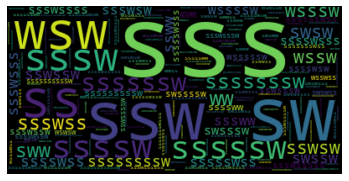

In [12]:
#Visualizing the common words in the reviews. The size of each word represents its frequency of occurrence in the data.
common_words=''
for i in data_v1.verified_reviews:
    i = str(i)
    tokens = i.split()
    common_words += " ".join(tokens)+" "
wordcloud = wordcloud.WordCloud().generate(common_words)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [15]:
#Encoding the target variable using ‘Label Encoder’ from the ‘sklearn’ library.
lb=LabelEncoder()
data_v1["sentiment"] = lb.fit_transform(data_v1["Sentiment"])

In [16]:
#Tokenizing and converting the reviews into numerical vectors.
tokenizer = Tokenizer(num_words=500, split=' ') 
tokenizer.fit_on_texts(data_v1['verified_reviews'].values)
X = tokenizer.texts_to_sequences(data['verified_reviews'].values)
X = pad_sequences(X)

In [17]:
#Building the LSTM model using the ‘Keras’ library. This step involves model initialization, adding required LSTM layers, and model compilation
model = Sequential()
model.add(Embedding(500, 120, input_length = X.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(176, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(2,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 7, 120)            60000     
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 7, 120)            0         
_________________________________________________________________
lstm (LSTM)                  (None, 176)               209088    
_________________________________________________________________
dense (Dense)                (None, 2)                 354       
Total params: 269,442
Trainable params: 269,442
Non-trainable params: 0
_________________________________________________________________
None


In [18]:
#Splitting the data into training and testing data.
y=pd.get_dummies(data_v1['sentiment'])
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state = 42)

In [19]:
#Training the model using training data.
batch_size=32
model.fit(X_train, y_train, epochs = 5, batch_size=batch_size, verbose = 'auto')

Epoch 1/5
2297/2297 [==============================] - 84s 35ms/step - loss: 0.5503 - accuracy: 0.7622
Epoch 2/5
2297/2297 [==============================] - 81s 35ms/step - loss: 0.5492 - accuracy: 0.7623
Epoch 3/5
2297/2297 [==============================] - 79s 34ms/step - loss: 0.5491 - accuracy: 0.7623
Epoch 4/5
2297/2297 [==============================] - 82s 36ms/step - loss: 0.5489 - accuracy: 0.7623
Epoch 5/5
2297/2297 [==============================] - 78s 34ms/step - loss: 0.5490 - accuracy: 0.7623


In [20]:
#Evaluating the model.
model.evaluate(X_test,y_test)

985/985 [==============================] - 5s 5ms/step - loss: 0.5472 - accuracy: 0.7640


[0.5471596121788025, 0.764011025428772]